# Исследование

In [1]:
from IPython.display import HTML

from tqdm import tqdm

import numpy as np
import pandas as pd

from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection

from catboost import CatBoostRegressor

import seaborn as sns
import matplotlib.pyplot as plt

from surprise.prediction_algorithms.slope_one import SlopeOne
from surprise.model_selection import cross_validate
from surprise.dataset import Dataset
from surprise.reader import Reader

from surprise.prediction_algorithms.matrix_factorization import (
    SVD, SVDpp
)
from surprise.prediction_algorithms.knns import (
    KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore
)

data = pd.read_parquet("ml_test_rec_sys.parquet")

## Изучение данных

Далее представлено несколько колонок полученного набора данных.

In [13]:
data.head()

,UserID,GameTitle,Rating,Age,Gender,Location,Device,PlayTimeOfDay,TotalPlaytimeInHours,PurchaseHistory,InvolvementLevel,UserReview,GameGenre,GameUpdateFrequency,SocialActivity,LoadingTimeInSeconds,GameSettingsPreference
0,user_1,game_1,2,50,Male,North America,Mobile,Night,48,Yes,Beginner,Negative,RPG,Frequent,Active,16,High Graphics
1,user_1,game_2,5,50,Male,North America,Mobile,Night,48,Yes,Beginner,Negative,Sports,Frequent,Low,30,High Performance
2,user_1,game_3,2,50,Male,North America,Mobile,Night,48,Yes,Beginner,Negative,Adventure,Occasional,Low,40,High Graphics
3,user_1,game_4,3,50,Male,North America,Mobile,Night,48,Yes,Beginner,Negative,RPG,Occasional,Moderate,24,High Graphics
4,user_1,game_5,5,50,Male,North America,Mobile,Night,48,Yes,Beginner,Negative,Action,Occasional,Active,50,Balanced


Не нашел в репозитории описания данных, поэтому, опишу как я интерпретировал таблицу, для того чтобы читающему было понятнее по какой причине я принял те или иные решения.

Удельная запись представляест собой пары комбинаций пользователь-игра и соответсвнно описание пользовательского опыта в той или иной игре.

### Описание колонок

Очевидно что:

- `UserID` - уникальный идентификатор пользователя;
- `GameTitle` - уникальный идетификатор игры;
- `Age` - возраст пользователя;
- `Gender` - пол пользователя;
- `PurchaseHistory` - если история покупок у этого пользователя;
- `GameGenre` - жанр рассматриваемой игры;
- `GameUpdateFrequency` - как часто обновляется данная игра;
- `GameSettingsPreference` - некоторая особенность игры.

Для некоторых колонок не до конца понятно описывают они пользователя (одинаковые в рамках пользоваля), игру (одинаковые в рамках игры) или описывают выбранную комбинацию пользователь игра (то есть потенциально могут быть уникальными вне привязки к пользователю или игре).

Так например колонка `Rating` может описывать средний рейтинг по игре или быть отражением того, что так ее оценил пользователь который сопряжен с ней в этой записи.

Для того чтобы проверить такие моменты, для каждого пользователя/игры подсчитаем сколько уникальных значений соответсвуют ему в той или иной колонке. В следующей ячейке проводится эта процедура - в результате для каждой колонки поставлено в соответсвие уникальные ли в ней значения по пользователю и по игре.

In [14]:
display(HTML("<b>По пользователю</b>"))
by_user = (
    (data.groupby("UserID").nunique() == 1)
    .all().replace({True:"Уникальное", False:"Не уникальное"})
)
by_game = (
    (data.groupby("GameTitle").nunique() == 1)
    .all().replace({True:"Уникальное", False:"Не уникальное"})
)
pd.DataFrame({
    "По пользователю" : by_user,
    "По игре" : by_game
}).loc[data.columns]

,По пользователю,По игре
UserID,NaN,Не уникальное
GameTitle,Не уникальное,NaN
Rating,Не уникальное,Не уникальное
Age,Уникальное,Не уникальное
Gender,Уникальное,Не уникальное
Location,Уникальное,Не уникальное
Device,Уникальное,Не уникальное
PlayTimeOfDay,Уникальное,Не уникальное
TotalPlaytimeInHours,Уникальное,Не уникальное
PurchaseHistory,Уникальное,Не уникальное


Можно сделать выводы про следующие колонки:

- `Rating` указывает как клиент из записи оценил соовтевующую игру;
- `Location` указывает на условно постоянный адрес пользоватля (а не то куда он играл в ту или иную игру);
- `Device` указывает на условно постоянный девайс пользователя (а не то каой девайс он исопльзовал для игры);
- `PlayTimeOfDay` указывает когда клиент предпочитает играть - уникальный по пользователю;
- `TotalPlaytimeInHours` то сколько **всего** играл пользователь во все игры, а не то соколько он играл именно в эту игру;
- `InvolvementLevel` - то насколько пользователь вовлечен в игровую платформу в целом а не в конкретную игру;
- `UserReview` - отзыв пользователя, видимо ко всей платформе в целом а не к конкретной игре;
- `SocialActivity` - не до конца понятно что это за колонка но это какая-то уникальная характеристика игры;
- `LoadingTimeInSeconds` - сколько данная игра загружалась, получается что у всех пользователей игра зпускается одинаково быстро.

**Целевая переменная**

Совершенно очевидно, что в данном случае следует использовать переменную `Rating` как целевую переменную (target) так как только она характеризует некотрое свойсво комбинации пользователь/игра, Все остальные переменны характеризую либо некоторого пользователя либо некоторую игру.

## Гипотезы

### Сопряженность свойсв игры/пользователя

Возможно женщинам и мужчинам нравятся разные игровые жанры. Поэтому подсчитаем раличные статистики по рейтингу в сопряженности пола и игрового жанра.

In [15]:
my_gb = data.groupby(["Gender", "GameGenre"])

display(HTML("<b style='font-size: 14px'>Количество наблюдений</b>"))
display(my_gb["Rating"].count().unstack())
display(HTML("<b style='font-size: 14px'>Средний рейтинг</b>"))
display(my_gb["Rating"].mean().unstack())
display(HTML("<b style='font-size: 14px'>Доля наблюдений с рейтингом 5</b>"))
display(my_gb["Rating"].apply(lambda sub_col: (sub_col > 4).mean()).unstack())

GameGenre,Action,Adventure,Puzzle,RPG,Simulation,Sports,Strategy
Gender,,,,,,,
Female,2920,4015,1460,2555,2555,3650,1095
Male,2520,3465,1260,2205,2205,3150,945
Other,2560,3520,1280,2240,2240,3200,960


GameGenre,Action,Adventure,Puzzle,RPG,Simulation,Sports,Strategy
Gender,,,,,,,
Female,2.994178,3.037360,2.939041,2.971820,3.008611,3.003288,3.044749
Male,2.994841,2.990765,2.949206,3.013605,3.016780,2.984444,3.082540
Other,3.010937,3.001705,3.013281,2.973214,3.008482,2.992812,2.984375


GameGenre,Action,Adventure,Puzzle,RPG,Simulation,Sports,Strategy
Gender,,,,,,,
Female,0.198630,0.201743,0.192466,0.199609,0.199217,0.200548,0.207306
Male,0.194444,0.194228,0.184921,0.200000,0.205896,0.193968,0.220106
Other,0.202734,0.203693,0.204687,0.194643,0.209375,0.194062,0.194792


Можно подумать, что мобильные платформы не такие производительные как стационарные поэтому стоит перепроверить может не стоит на мобилы рекомендовать высокопроизводительные игры. Закономерностей не обнаружено.  

In [16]:
my_gb = data.groupby(["GameSettingsPreference", "Device"])

display(HTML("<b style='font-size: 14px'>Количество наблюдений</b>"))
display(my_gb["Rating"].count().unstack())
display(HTML("<b style='font-size: 14px'>Средний рейтинг</b>"))
display(my_gb["Rating"].mean().unstack())
display(HTML("<b style='font-size: 14px'>Доля наблюдений с рейтингом 5</b>"))
display(my_gb["Rating"].apply(lambda sub_col: (sub_col > 4).mean()).unstack())

Device,Console,Mobile,PC
GameSettingsPreference,,,
Balanced,3924,4032,4044
High Graphics,7194,7392,7414
High Performance,5232,5376,5392


Device,Console,Mobile,PC
GameSettingsPreference,,,
Balanced,2.994139,3.001984,3.010386
High Graphics,2.981790,3.021645,3.004181
High Performance,2.959098,2.989955,3.036165


Device,Console,Mobile,PC
GameSettingsPreference,,,
Balanced,0.200306,0.200893,0.199060
High Graphics,0.194746,0.202922,0.197194
High Performance,0.189220,0.201079,0.210497


### Решающее дерево

Предположения опирающиеся на бизнес смысл переменных не дают никакого результата. Пойдем от обратного. Попробуем построить простенькую, легко интерпретируемую модельку и посмотрим на результат. Возьмем, например, не глубокое решающее дерево и попробуем из его решений выловить закономерности. В следующей ячейке подогнано и визуализировано решающее дерево. Похоже, анализ среднего рейтинга нидает никакого внятного результата.

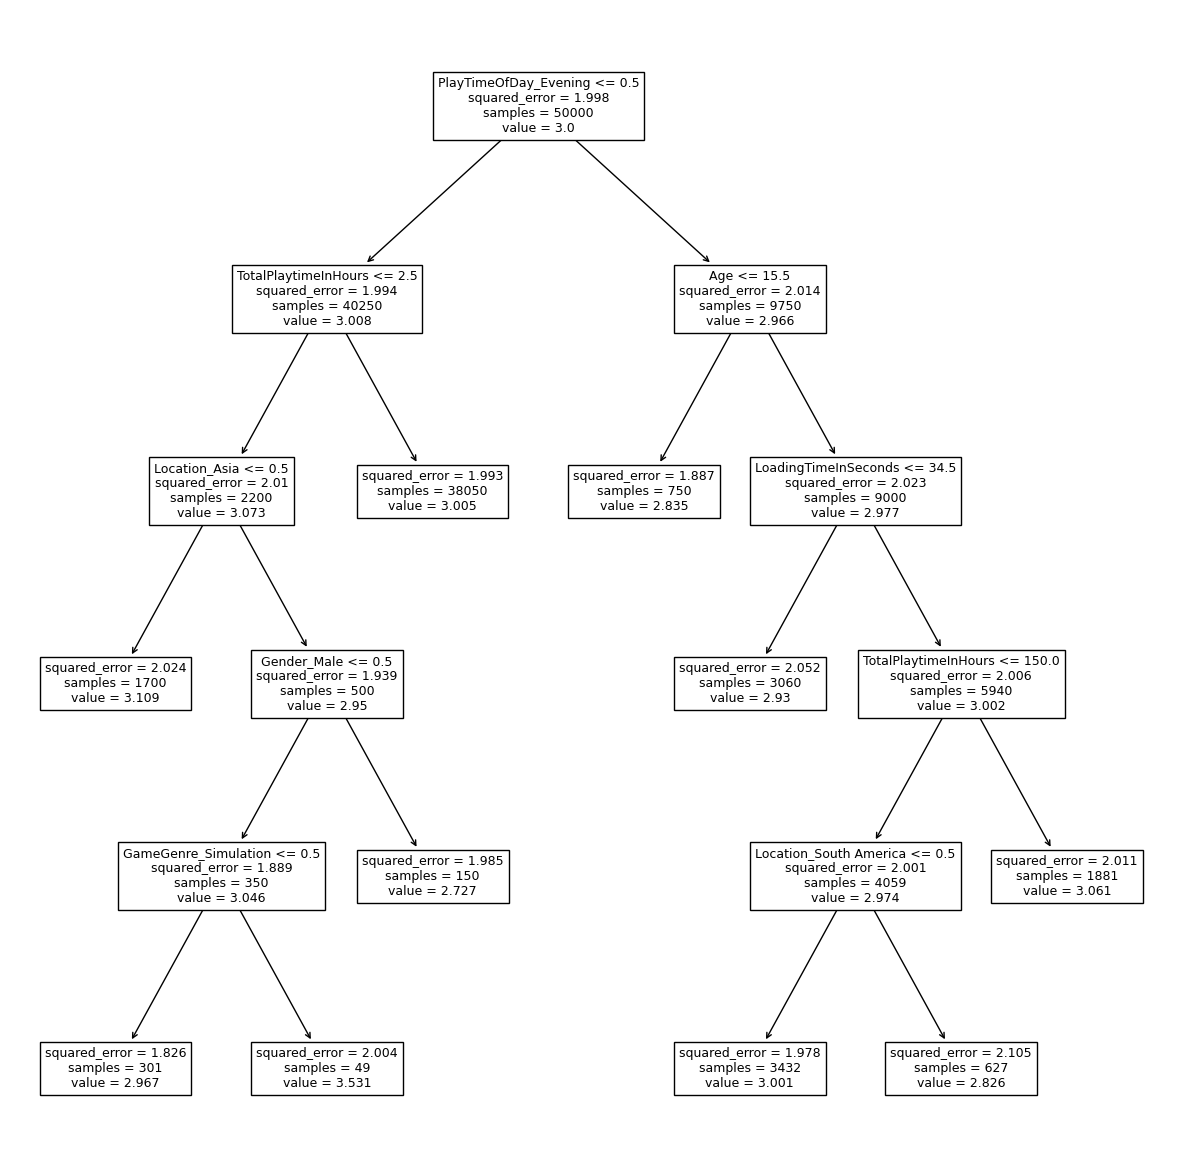

In [17]:
X = data.drop(["UserID", "GameTitle", "Rating"], axis = 1)
X = pd.get_dummies(X, drop_first=True)
y = data["Rating"]

clf = tree.DecisionTreeRegressor(max_leaf_nodes = 10)
clf.fit(X, y)

plt.figure(figsize = [15,15])
tree.plot_tree(clf, feature_names=X.columns)
plt.show()

### Предпочтения пользователя

Предположим, пользователь играет не первый день (выборка это допускает). Тогда, ему рационально подсовывать игры похожие на те которые раньше он оценивал хорошо.

В кочестве примера того, что я имею ввиду рассмотрим средние рейтинги каждого пользователя играм по требованиям игры. Далее представлено как игры разной требовательности в среднем оценивали первый и второй пользователи. Видно, что первый пользователь предпочитает игры которые шустро запускаются на его устройсве. А второй любит игры в которых красивая графика. Так же в контесте именно этой переменной, стоит обратить внимание, что "Balanced" игры занимают промежуточное состояние.

In [18]:
data.groupby(
    ["GameSettingsPreference", "UserID"]
)["Rating"].mean().unstack().loc[
    ["High Graphics", "Balanced", "High Performance"]
][["user_1", "user_2"]]

UserID,user_1,user_2
GameSettingsPreference,,
High Graphics,2.772727,3.227273
Balanced,3.083333,3.166667
High Performance,3.500000,2.312500


Теперь, попробуем каждому пользователю поставить в сооветсвие тот `GameSettingsPreference` который ему наилучшим образом подходит - получится уже некоторая характеритика пользователя. Поставим в сооветсвие предпочтениям пользователя относительно производительностей игр в которые он играл производетельности игр которые мы потенциально можем ему рекомендовать. 

In [19]:
temp = data.copy()

u_GameSettingsPreference = data.groupby(["UserID"])[[
    "GameSettingsPreference",
    "Rating"
]].apply(
    lambda sub:
        sub.groupby("GameSettingsPreference")["Rating"].mean().idxmax()
)
u_GameSettingsPreference.name = "u_GameSettingsPreference"
temp = pd.merge(
    temp,
    u_GameSettingsPreference,
    left_on="UserID",
    right_index=True
)

my_gb = temp.groupby(["u_GameSettingsPreference", "GameSettingsPreference"])

display(HTML("<b style='font-size: 14px'>Количество наблюдений</b>"))
display(my_gb["Rating"].count().unstack())
display(HTML("<b style='font-size: 14px'>Средний рейтинг</b>"))
display(my_gb["Rating"].mean().unstack())
display(HTML("<b style='font-size: 14px'>Доля наблюдений с рейтингом 5</b>"))
display(my_gb["Rating"].apply(lambda sub_col: (sub_col > 4).mean()).unstack())

GameSettingsPreference,Balanced,High Graphics,High Performance
u_GameSettingsPreference,,,
Balanced,4164,7634,5552
High Graphics,3912,7172,5216
High Performance,3924,7194,5232


GameSettingsPreference,Balanced,High Graphics,High Performance
u_GameSettingsPreference,,,
Balanced,3.367915,2.903589,2.864733
High Graphics,2.747188,3.231177,2.801572
High Performance,2.868502,2.880178,3.327408


GameSettingsPreference,Balanced,High Graphics,High Performance
u_GameSettingsPreference,,,
Balanced,0.272574,0.178150,0.178134
High Graphics,0.152352,0.246375,0.151265
High Performance,0.170744,0.171810,0.272936


На главных диоганалях некоторых из табличек наметился некоторый рост статистик описывающих шанс того что пользователь поставит рейтинг той или иной игре повыше. Уже что-то, но, конечно, такой подход серьезно подвержен переобучению, поэтому самые попрулярные для того или иного пользователя виды игр можно подбирать на одной подвыборке а оценивать насколько эти игры популярны у того или иного пользователя следует на тестовой выборке.

Для каждой комбинации пользователь/игра посмотрим сооветсвуют ли характеристики данной игры той тем значениям характеристик у которых, по этому пользователю, наблюдалась лучшая средняя оценка. При том, оценивать какое значение характеритики больше всего нравилось пользователю будем на тренирововчной выборке а результат подсчитаем так-же - на валидационной.

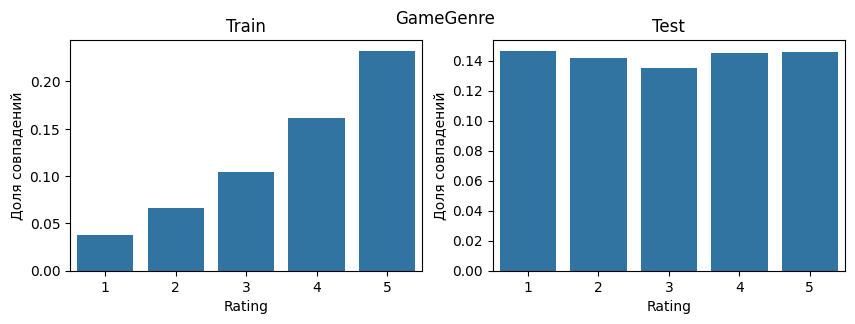

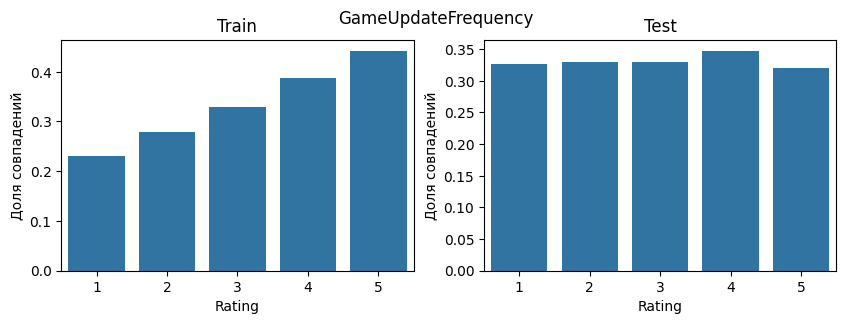

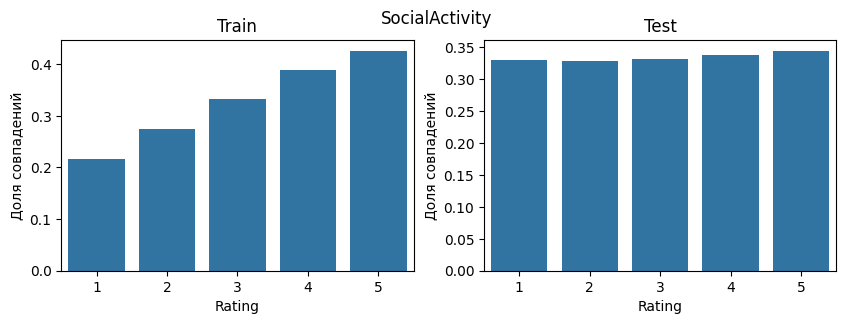

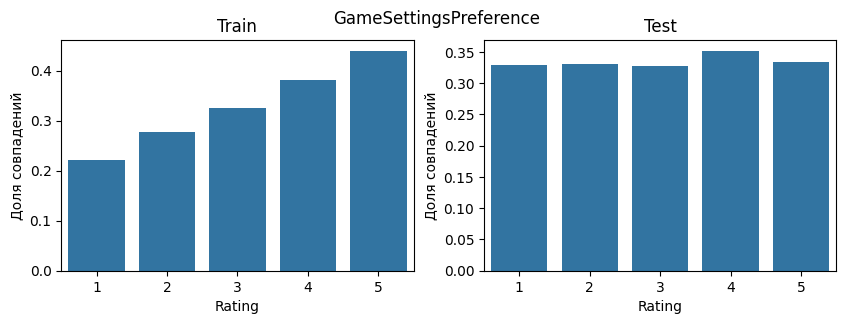

In [20]:
X = data.drop("Rating", axis = 1)
y = data["Rating"]

# разбиение на test/train
X_train, X_test, y_train, y_test = train_test_split(
    X,y, train_size = 0.8, stratify=X["UserID"], random_state=10
)

def get_highest_mean_rating(sub_frame):
    '''
        Для переменных переданного sub_frame
        вернуть лучшие категории в смысле
        наибольшего среднего значения y_train
    '''
    return pd.Series({
        col:y_train.groupby(sub_frame[col]).mean().idxmax()
        for col in sub_frame
    })

# ставим в соответсвие те значения категориальных
# характеристик игр, которые пользователям нравились
# больше всего
best_cat_for_user = X_train.groupby("UserID")[[
    'GameGenre', 
    'GameUpdateFrequency',
    'SocialActivity', 
    'GameSettingsPreference'
]].apply(get_highest_mean_rating)

# а теперь растягиваем это в исхходную размерность
# набора данных
best_cat_for_user = (
    data[["UserID", "GameTitle"]]
    .join(best_cat_for_user, on="UserID")
    .drop(["UserID", "GameTitle"], axis = 1)
)
# и получаем бинарную переменную которая указыват на то
# соответсвует ли данная метрика
temp = data[best_cat_for_user.columns] == best_cat_for_user

temp_test = temp.loc[y_test.index].groupby(y_test).mean()
temp_train = temp.loc[y_train.index].groupby(y_train).mean()

for c in temp_train:
    
    plt.figure(figsize = [10, 3])
    plt.suptitle(c)
    
    plt.subplot(121)
    plt.title("Train")
    sns.barplot(data=temp_train, x=temp_train.index, y=c)
    plt.ylabel("Доля совпадений")
    plt.subplot(122)
    plt.title("Test")
    sns.barplot(data=temp_test, x=temp_test.index, y=c)
    plt.ylabel("Доля совпадений")

В релультате получается что на тренировочноый выборке различие оцень яркое, а на валидационной нет никакого. Получается весь эффект обусловлен феноменоменом переобучения и за ним не стоит реальной закономерности.

## Модели

Подготовим разбивку test/train которая будет нам полездна при валидации финальных алгоритмов. Разбивка сделана так, чтобы каждый пользователь в раной степени был представлен и в test и в train. 

Так же объявлен словарь `models_results`, в котором для каждой модели под ключем соответсвующим этой модели должна быть `pandas.DataFrame` в которой элементы $x_{i,j}|j=\overline{1,10}$ - дейсвительный рейтинг $j$-й по предпочтению игры для $i$-го пользователя. То есть если $x_{i,j} = 4|i=\text{user\_15},j=3$, то это значит, что исследуемая модель пользователю user_15 червертой предложила игру которой этот пользователь в дейсвительности поставил рейтинг 4.

In [23]:
data_train, data_test, X_train, X_test, y_train, y_test = \
model_selection.train_test_split(
    data, data.drop("Rating", axis=1), data["Rating"],
    random_state=10, train_size=0.8,
    stratify = data["UserID"]
)

# штука часто используется в различных
# ячейках этого раздела - можно понимать как
# глобальную настройку
reader = Reader(rating_scale=(1, 5))

models_results = {}

### Случайные рекомендации

Для того, чтобы лучше ориентироваться насколько хорошо мы смогли подсунуть рекомендации той или иной моделью будет здорово сравнить результаты со случайным раскидывателем рейтиногов. За одно покажу как должен быть для каждой модели заполнен `models_results`. В результате для каждого пользователя накидал 10 случайных его рейтингов из тестового набора данных - хорошая модель накидает не случайных :).

In [24]:
models_results["dummy_model"] = data_test.groupby("UserID")["Rating"].apply(
    lambda user_subset: pd.Series(
        {i+1:rait for i, rait in enumerate(user_subset.sample(frac=1, random_state=10))}
    )
).unstack()
models_results["dummy_model"].sample(3, random_state=10)

,1,2,3,4,5,6,7,8,9,10
UserID,,,,,,,,,,
user_856,4,1,4,2,4,4,5,5,2,2
user_96,2,1,3,3,2,4,2,5,1,4
user_589,5,1,4,5,3,2,1,2,5,5


### Коллаборативная фильтрация

Я до бескончености могу пытаться найти связи в предложенной выборке. Но уже начинают закрадывать сомнения, что вы какую-либо связь заложили. Поэтому попробуем колоборативные подходы.

- https://surprise.readthedocs.io/en/stable;
- https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b.

#### Подбор модели

Прокрутим несколько моделек, по типу того как показано это сделано в статье на TDS. Лучший подход попробуем валидировать более основательно.

In [12]:
surp_dataset = Dataset.load_from_df(data[["UserID", "GameTitle", 'Rating']], reader)

algorithms = [
    SlopeOne(), 
    SVD(), 
    SVDpp(),
    KNNBaseline(verbose=False), 
    KNNBasic(verbose=False), 
    KNNWithMeans(verbose=False), 
    KNNWithZScore(verbose=False)
]

benchmark = []
for algorithm in tqdm(algorithms):
    results = cross_validate(
        cv=3, verbose=False,
        algo=algorithm, 
        data=surp_dataset,
        measures=['RMSE'],
    )
    
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp["Algorithm"] = str(algorithm).split(' ')[0].split('.')[-1]
    benchmark.append(tmp)

results_matrix = \
    pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:57<00:00,  8.26s/it]


In [14]:
display(HTML("<b style='font-size: 15px'>Результаты вычислений</b>"))
display(results_matrix)
best_model_res = results_matrix["test_rmse"].idxmin()
display(HTML(f"<b style='font-size: 15px'>Лучшая модель - {best_model_res}</b>"))

,test_rmse,fit_time,test_time
Algorithm,,,
KNNBasic,1.432988,0.300956,4.229839
SlopeOne,1.436931,0.023069,0.182523
KNNBaseline,1.438951,0.321708,3.965258
KNNWithZScore,1.444105,0.316511,3.613474
KNNWithMeans,1.444711,0.316089,3.728422
SVD,1.513780,0.231744,0.067686
SVDpp,1.582364,1.276145,0.470628


#### Результаты

Обучаем модель на оющум train и котовим пердсказания для общего test.

In [25]:
data_train_surp = Dataset.load_from_df(
    data_train[["UserID", "GameTitle", 'Rating']], reader
)

# подготовка модели
model = KNNBasic(verbose=False)
model = model.fit(data_train_surp.build_full_trainset())

# раскатываем предсказания на test
model_scores = data_test.apply(
    lambda row: model.predict(
        row["UserID"], row["GameTitle"]
    ).est, axis = 1
)

# получаем рейтинги для каждого предсказания модели
models_results["collaborative_model"] = model_scores.groupby(data_test["UserID"]).apply(
    lambda subset:
        data_test.loc[subset.index, "Rating"].loc[
            model_scores.loc[subset.index].
            sort_values(ascending=False).index
        ].set_axis(range(1, len(subset) + 1))
).unstack()

### Контентный подход

Несмотря на то, что в предложенном наборе данных неудалось найти хоть каких либо взаимосвязей `catboost` иногда творит чудеса. Поэтому попробуем подогнать его под предложенную выборку.

In [26]:
model = CatBoostRegressor(
    cat_features=X_train.select_dtypes("O").columns.to_list(),
    random_state=11,
    silent = True
).fit(X_train, y_train)

predict_test = pd.Series(model.predict(X_test), index=X_test.index)

models_results["content_model"] = model_scores.groupby(data_test["UserID"]).apply(
    lambda subset:
        data_test.loc[subset.index, "Rating"].loc[
            predict_test.loc[subset.index].
            sort_values(ascending=False).index
        ].set_axis(range(1, len(subset) + 1))
).unstack()

## Оценка качетсва

Будем считать, что рекомендация хорошая, если пользователь присвоил модели рейтинг 5. Дейсвуя в этом предположении подсчитаем некоторые популярные метрики рекомендательных систем:

In [80]:
hitrate = lambda k: {
    key:(res.iloc[:, :k] == 5).any(axis=1).mean()
    for key, res in models_results.items()
}
precision = lambda k:{
    key:((res.iloc[:, :k] == 5).mean(axis=1)).mean()
    for key, res in models_results.items()
}
recall = lambda k:{
    key:((res.iloc[:,:k] == 5).sum(axis=1)/(res == 5).sum(axis=1)).fillna(1).mean()
    for key, res in models_results.items()
}

pd.DataFrame(
    {
        **{f"hitrage@{i}":hitrate(i) for i in [1,3,5]},
        **{f"precision@{i}":precision(i) for i in [1,3,5]},
        **{f"recall@{i}":recall(i) for i in [1,3,5]}
    }
)

,hitrage@1,hitrage@3,hitrage@5,precision@1,precision@3,precision@5,recall@1,recall@3,recall@5
dummy_model,0.194,0.473,0.688,0.194,0.190000,0.2006,0.199343,0.364119,0.556229
collaborative_model,0.182,0.507,0.696,0.182,0.205000,0.2088,0.192593,0.390669,0.583821
content_model,0.185,0.467,0.657,0.185,0.190333,0.1948,0.187043,0.356026,0.534045


В результате, похоже что модели, что я настроил почти не отличаются от случайного угадывания. Но похоже, что в выборку не завезли взаимосвязей - это случайные значения. Редко бывает так, что может быть, не идеальные но все общепринятые методы ни дают НИКАКОГО результата. 

Но, если долго присматриватся, может показаться, что модель опирающаяся на коллаборативный подход немножко превосходит модель случайного угадывания. Поэтому для того чтобы показать как я умею подготовливать модели для введения в прод будем использовать именно ее.